<a href="https://colab.research.google.com/github/deshanchathusanka/abuses-biases-blessing-of-data/blob/main/research/SIDU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Simularity Difference And Uniqueness(SIDU)</h1>

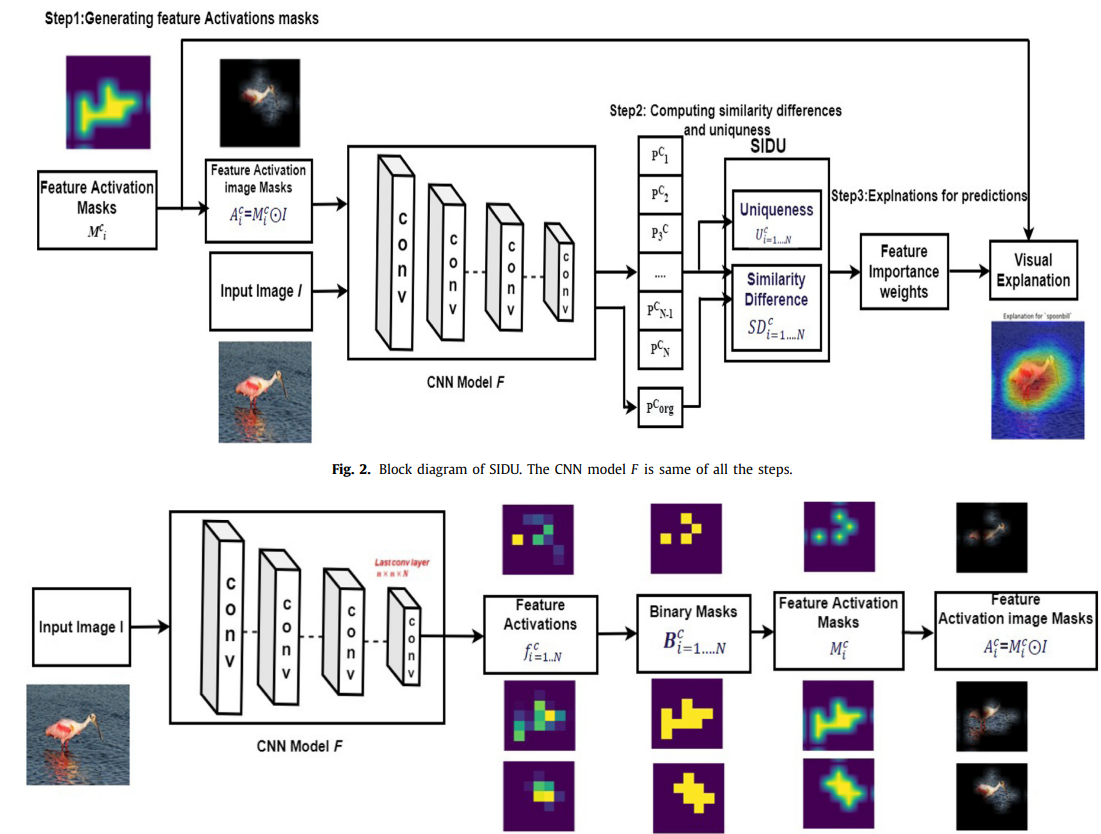

<h2>1. Initial Setup</h2>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ln -s "/content/drive/My Drive/research/images" 
# !ln -s "/content/drive/My Drive/test_images" 
# !ln -s "/content/drive/My Drive/research/evaluation.py"
# !ln -s "/content/drive/My Drive/research/utils.py"  
# !ln -s "/content/drive/My Drive/research/synset_words.txt" 

In [ ]:
!pip install tqdm

<h2>2. Import Required Packages</h2>

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.python.keras.models import load_model
from keras import backend as K
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cdist
from tensorflow.keras import layers,models

from os.path import join, exists
from evaluation import CausalMetric, auc, gkern

<h2>3. Load an Image</h2>

Shape of Processed Image : (1, 224, 224, 3)


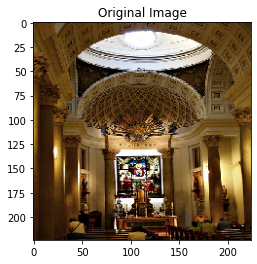

In [ ]:
def load_img(path, input_size):
    """ to load the image for the pretrained model which are trained from imagenet """
    img = image.load_img(path, target_size = input_size)
    numpy_image = image.img_to_array(img) ## (224, 224, 3)
    input_image_tensor = np.expand_dims(numpy_image, axis=0) ## (1, 224, 224, 3)
    processed_image = preprocess_input(input_image_tensor) ## (1, 224, 224, 3)
    return img, processed_image

IMG_HEIGHT = 224  # H
IMG_WIDTH = 224   # W
CHANNEL = 3
INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNEL)

####################### Testing ##############################
image_path = 'images/ILSVRC2012_val_00001798.JPEG'
img, processed_image = load_img(path = image_path, input_size = (IMG_HEIGHT, IMG_WIDTH))
print(f'Shape of Processed Image : {processed_image.shape}')

plt.figure()
plt.title(label = 'Original Image')
plt.imshow(img)
plt.show()


<h2>4. Load The Blackbox Model</h2>

In [ ]:
f_restnet = ResNet50()
f_restnet.summary()

####  to see the last layer of CNN use base_model.summary() 
features_model = Model(inputs = f_restnet.input, outputs = f_restnet.get_layer('conv5_block3_out').output)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

<h2>5. Predict The Label </h2>

In [ ]:
def class_name(idx):
  """extract class name from id"""
  return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

predictions = f_restnet(processed_image)
predicted_label = np.argmax(a = predictions, axis = 1)[0]
print(f'Shape of pthe prediction vector : {predictions.shape}')
print(f'Predicted Label : {class_name(predicted_label)}')

Shape of pthe prediction vector : (1, 1000)
Predicted Label : vault


<h2>6. Generate Binary Grid</h2>

<h3>6.1 RISE Method (Randomise Binary Grid)</h3>

Size of random grid(RISE) :  (2048, 7, 7)


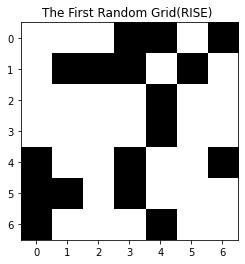

In [ ]:
N = 2048 #### Number of masks
s = 7   #### shape of the grid

########## Create N grids of size s x s containing random 0's and 1's with equal proability ################
binary_grid_rise = np.random.randint(low = 2, size = (N, s, s)) # Generate numbers between [0, low) ::: (2048, 8, 8)
binary_grid_rise = binary_grid_rise.astype('float32') ## cast to float data type
print("Size of random grid(RISE) : ",binary_grid_rise.shape)

######### View the first grid #############
plt.gray()
plt.title(label = 'The First Random Grid(RISE) ')
plt.imshow((binary_grid_rise[0]))
plt.show()


<h3>6.2 SIDU Method</h3>

<h4>6.2.1 Generate Feature Activation Grid</h4>

Shape of feature activation grid : (2048, 7, 7)


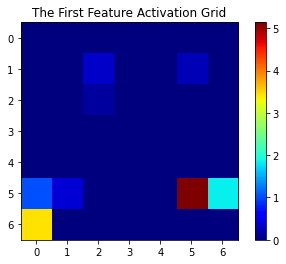

In [ ]:
### extract the last convlution layers' feature activation maps of the model
feature_activation_maps = features_model.predict(processed_image) # output of the 5th convolutional block = (1, 7, 7, 2048)
last_conv_output = np.squeeze(feature_activation_maps) # remove unit size dimension(batch size) = (7, 7, 2048)
grid_sidu = np.rollaxis(last_conv_output, 2, 0) ## (2048, 7, 7) = last convolution layer output
print(f'Shape of feature activation grid : {grid_sidu.shape}')

############### View one feature activation grid ###############
plt.figure()
plt.title(label = 'The First Feature Activation Grid')
plt.imshow(grid_sidu[0], cmap = 'jet')
plt.colorbar()
plt.show()

<h4>6.2.2 Generate Binary Grid</h4>

Generating masks: 100%|██████████| 2048/2048 [00:00<00:00, 129577.24it/s]


Shape of binary grid : (2048, 7, 7)


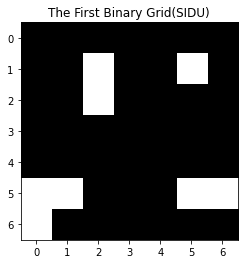

In [ ]:
N = len(grid_sidu) ## 2048
binary_grid_sidu = np.empty((N, 7, 7)) ## (2048, 7, 7) = empty array

for i in tqdm(range(N), desc='Generating masks'): ## Progress bar
  """extracting the each feature maps of last convlution layer """
  conv_out = last_conv_output[:,:,i] ## (7, 7) Pixel values
  
  """converting last convlayer to binary mask"""
  conv_out = conv_out > 0.1 ## (7, 7) Boolean values
  conv_out = conv_out.astype('float32') ## (7, 7) Binary values
  binary_grid_sidu[i,:, :] = conv_out 

############### View one feature activation grid ###############
print(f'Shape of binary grid : {binary_grid_sidu.shape}')
plt.figure()
plt.title(label = 'The First Binary Grid(SIDU)')
plt.imshow(binary_grid_sidu[0])

plt.show()     

<h2>7. Generate Mask(Bi-linear Interpolation)</h2>

In [ ]:
def generate_mask(grid, s) : 
  """
  Up-sampling ::: Bi-linear Interpolation
  Input :
    grid = (2048, 7, 7)
  Output :
    masks = (2048, 224, 224)
  """
  masks = np.empty(shape = (N, IMG_HEIGHT, IMG_WIDTH ))
  cell_size = np.ceil(np.array((IMG_HEIGHT,IMG_WIDTH)) / s)
  up_size = (s) * cell_size

  for i in range(N):
      # Random shifts
      x = np.random.randint(0, cell_size[0])
      y = np.random.randint(0, cell_size[1])
      # Linear upsampling and cropping
      masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
  return masks

Shape of RISE masks : (2048, 224, 224)


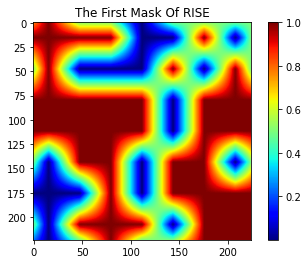

In [ ]:
################# Test ::: RISE #####################
masks_rise = generate_mask(binary_grid_rise, s)

print(f'Shape of RISE masks : {masks_rise.shape}')
plt.figure()
plt.title(label = 'The First Mask Of RISE')
plt.imshow(masks_rise[0], cmap = 'jet')
plt.colorbar()
plt.show() 

Shape of SIDU masks : (2048, 224, 224)


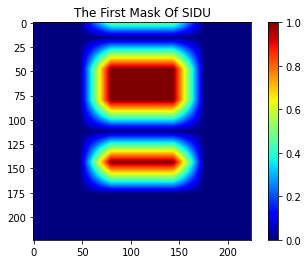

In [ ]:
################# Test ::: SIDU #####################
mask_sidu = generate_mask(binary_grid_sidu, s)

print(f'Shape of SIDU masks : {mask_sidu.shape}')
plt.figure()
plt.title(label = 'The First Mask Of SIDU')
plt.imshow(mask_sidu[50], cmap = 'jet')
plt.colorbar()
plt.show() 

<h2>8. Generate Masked Images</h2>

In [ ]:
def generate_masked_images(masks, processed_image) :
  """
  Input :
    masks = (2048, 224, 224)
    processed_image = (1, 224, 224, 3)
  Output :
    masked_images = (2048,224, 224, 3)
  """
  masks = masks.reshape(-1, IMG_HEIGHT,IMG_WIDTH, 1) #### insert dimension for channels
  masked_images = processed_image*masks
  return masked_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of masked images : (2048, 224, 224, 3)


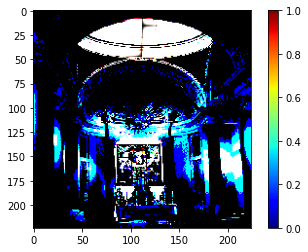

In [ ]:
################## Test Masked Images ::: RISE ####################
masked_images_rise = generate_masked_images(masks_rise, processed_image)

print(f'Shape of masked images : {masked_images_rise.shape}')
plt.figure()
plt.imshow(masked_images_rise[0], cmap = 'jet')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of masked images : (2048, 224, 224, 3)


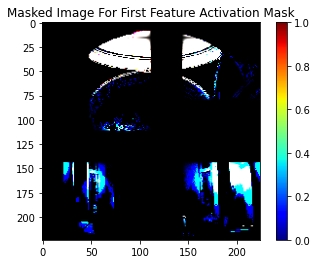

In [ ]:
################## Test Masked Images ::: SIDU ####################
masked_images_sidu = generate_masked_images(mask_sidu, processed_image)

print(f'Shape of masked images : {masked_images_sidu.shape}')
plt.figure()
plt.title(label = 'Masked Image For First Feature Activation Mask')
plt.imshow(masked_images_sidu[0], cmap = 'jet')
plt.colorbar()
plt.show()

<h2>8. Execute The Classifier For All Masked Images</h2>

In [ ]:
def predict_batch(model, images, batch_size) : 
  preds = []

  for i in tqdm(range(0, N, batch_size), desc='Predicting Batch'):
      preds.append(model.predict(images[i:min(i+batch_size, N)]))
      
  ####################### predictions for masked images #################################
  preds = np.concatenate(preds) ## (2048, 1000)

  return preds

In [ ]:
######################### RISE Methods ###############################
preds_rise = predict_batch(f_restnet, masked_images_rise, 100)
print(f'Shape of batch prediction output : {preds_rise.shape}')

Predicting Batch: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]

Shape of batch prediction output : (2048, 1000)


In [ ]:
######################### SIDU Methods ###############################
preds_sidu = predict_batch(f_restnet, masked_images_sidu, 100)
print(f'Shape of batch prediction output : {preds_sidu.shape}')

Predicting Batch: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]

Shape of batch prediction output : (2048, 1000)


<h2>9. Generate Salience Map</h2>
The salience map is generated as weighted average of masks.

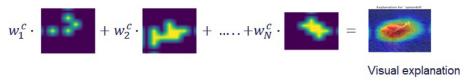

In [ ]:
def plot_sal_map(weights, masks, model, processed_image, input_image_size, method) :
  p1 = 0.5
  sal = weights.T.dot(masks.reshape(N, -1)).reshape(-1, *input_image_size) ## (1000, 224, 224)
  sal = sal / N / p1

  ############### plot original image and heat map ############################
  pred_vec= model.predict(processed_image) ## (1, 1000)
  pred = np.argmax(pred_vec)
  class_idx = pred
      
  plt.title(f'{method} Explanation for {format(class_name(class_idx))}')
  plt.axis('off')
  ################ plot original image ##################
  plt.imshow(img) 
  ################ plot salience map ###################
  plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
  plt.axis('off') 
  plt.show()

  return sal


<h3>9.1 RISE Heat Map</h3>

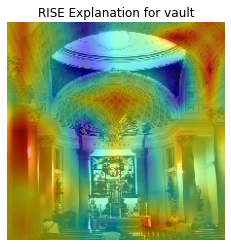

In [ ]:
###################### RISE Method  ##################
weights_rise = preds_rise
sal_rise = plot_sal_map(weights_rise, masks_rise, f_restnet, processed_image, INPUT_SIZE, 'RISE')

<h3>9.2 SIDU Heat Map</h3>

In [ ]:
###################### SIDU Method ####################
def kernel(d, kernel_width):
    """ 
    computing the exponential weights for the differences
    Input :
        d = (2048, 1000)
        kernel_width = 0.25
    """
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) ## (2048, 1000)

def sim_differences(pred_org, preds):
    """
    Computing the similarity differences
    Input : 
        pred_org = (1, 1000)
        preds = (2048, 1000)
    """
    diff = abs(pred_org - preds) ## alsolute difference : (2048, 1000)
    similarities = kernel(diff, 0.25) ## gaussian kernel weights : (2048, 1000)
    return similarities, diff


def normalize(array):
      return (array - array.min()) / (array.max() - array.min() + 1e-13)   
  
def uniqness_measure(masks_predictions):
    """ 
    computing the uniqness between the feature maps 
    Input :
        masks_predictions = (2048, 1000)
    """
    distance_filters = cdist(masks_predictions, masks_predictions) ## (2048, 2048) : Euclidient distance
    sum_all_cdist =(distance_filters).sum(axis=1) ## (2048, 1)
    sum_all_cdist = normalize(sum_all_cdist) ## (2048, 1)
    return sum_all_cdist

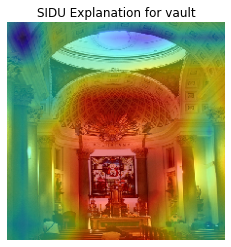

In [ ]:
####################### calculate similarity difference and uniqueness ################
pred_org = f_restnet.predict(processed_image) ## (1, 1000)
similerity_measures, diff = sim_differences(pred_org, preds_sidu) ## (2048, 1000)
uniqness_measures = uniqness_measure(preds_sidu) ## (2048,)
uniqness_measures = uniqness_measures.reshape(-1, 1)
weights_sidu = np.multiply(similerity_measures, uniqness_measures) ## (2048, 1000)

sal_sidu = plot_sal_map(weights_sidu, mask_sidu, f_restnet, processed_image, INPUT_SIZE, 'SIDU')

<h2>10. Evaluation with Causal Metrics</h2>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d

from utils import *
from evaluation import CausalMetric, auc, gkern


cudnn.benchmark = True

###############################################################################

# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)



#################################################################################
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

#############################################################################

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('test_images/ILSVRC2012_val_00000102.JPEG')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

##########################################################################
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)



############################# SIDU #############################################

h = insertion.single_run(img, sal_sidu, verbose=1)
print(f'AOC(Insertion, SIDU) : {auc(h)}')

h = deletion.single_run(img, sal_sidu, verbose=1)
print(f'AOC(Deletion, SIDU) : {auc(h)}')

############################# RISE #############################################


h = insertion.single_run(img, sal_rise, verbose=1)
print(f'AOC(Insertion, RISE) : {auc(h)}')

h = deletion.single_run(img, sal_rise, verbose=1)
print(f'AOC(Deletion, RISE) : {auc(h)}')





<h2>11. References</h2>

**Colormap Used In Salience Map**

jet_color_map.png


**Additional Study**

* Bilinear Interpolation

* ImageNet dataset : 1000 object classes

**References**

[1] Muddamsetty, S. M., Jahromi, M. N., Ciontos, A. E., Fenoy, L. M., & Moeslund, T. B. (2022). Visual explanation of black-box model: Similarity Difference and Uniqueness (SIDU) method. Pattern Recognition, 127, 108604.

[2] Petsiuk, V., Das, A., & Saenko, K. (2018). Rise: Randomized input sampling for explanation of black-box models. arXiv preprint arXiv:1806.07421.

**Links**

https://academictorrents.com/collection/imagenet-lsvrc-2015